### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Tanzid Sultan`

**Student ID:**     `1430660`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [37]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

In [38]:
import numpy as np

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])


In [39]:
import cv2
from matplotlib import pyplot as plt

In [40]:
# read in test images as grayscale
test_img = cv2.imread('./cameraman.png', cv2.IMREAD_GRAYSCALE)
test_img1 = cv2.imread('./cat.png', cv2.IMREAD_GRAYSCALE)
test_img2 = cv2.imread('./zebra.png', cv2.IMREAD_GRAYSCALE)
test_img3 = cv2.imread('./kodim21.png', cv2.IMREAD_GRAYSCALE)

#### Functions for computing the laplacian pyramid of an image and image reconstruction are implemented below (along with several other helper functions)

In [41]:
'''
    helper function for 2d convolution of an image with a given kernel/filter
    
    Parameters:
    I - 2d image array
    kernel - 2d filter array
'''
def filter(I, kernel):
    return cv2.filter2D(I, -1, kernel)


'''
    helper function for downsampling an image by a factor of 1/2
   
    Parameters:
    I - 2d image array
    '''
def downsample(I):
    # keep every other row/column
    D = I[1::2, 1::2]
    return D


'''
    helper function for upsampling an image by factor of 2

    Parameters:
    I - 2d image array
'''
def upsample(I):
    height = I.shape[0] 
    width =  I.shape[1]
    U = np.zeros(shape=(2*height, 2*width))
    # upsampled image will contain zeros on every other row/column
    for i in range(height):
        for j in range(width):
            U[2*i, 2*j] = I[i,j]

    return U        


'''
    function for creating a laplace pyramid for an input image

    Parameters:
    I - 2d image array
    g - 2d gaussian filter array
    n - number of pyramid levels
'''
def createLaplacePyramid(I, g, n):
    # list of pyramid images
    L_pyramid = []
    # iterate over pyramid image levels 
    for i in range(n):
        if i < (n-1):
            # filter the image with gaussian kernel
            F = filter(I, g)
            # downsample the filtered image
            D = downsample(F)
            # upsample the image then filter by the gaussian kernel and increase brightness by factor of 4 to compensate for upsampling
            U = filter(upsample(D), 4*g)
            # compute difference image for this level
            L = I - U
            L_pyramid.append(L)
            # use downsampled image as input for next level
            I = D
        else:
            # the last level will not be processed any further
            L_pyramid.append(I)    

    return L_pyramid        


'''
    function for reconstructing image from its laplace pyramid representation

    Parameters:
    L - laplacian pyramid 
    g - 2d gaussian filter array
'''
def reconstructFromPyramid(L, g):
    n = len(L)
    I = L[-1]
    for i in range(n-2, -1,-1):
        # upsample the pyramid image and apply filter compensated for brightness
        U = filter(upsample(I), 4*g)
        I = U + L[i]

    return I


'''
# function for creating a gaussian pyramid for an input image
def createGaussianPyramid(I, g, n):
    # list of pyramid images
    L_pyramid = [I]
    # iterate over pyramid image levels 
    for i in range(n):
        # filter the image with gaussian kernel
        F = filter(I, g)
        # downsample the filtered image
        D = downsample(F)
        L_pyramid.append(D)
        # use downsampled image as input for next level
        I = D  

    return L_pyramid   
'''

'\n# function for creating a gaussian pyramid for an input image\ndef createGaussianPyramid(I, g, n):\n    # list of pyramid images\n    L_pyramid = [I]\n    # iterate over pyramid image levels \n    for i in range(n):\n        # filter the image with gaussian kernel\n        F = filter(I, g)\n        # downsample the filtered image\n        D = downsample(F)\n        L_pyramid.append(D)\n        # use downsampled image as input for next level\n        I = D  \n\n    return L_pyramid   \n'

In [42]:
'''
    Some functions for creating nice plots
'''
def plotPyramid(img, pyramid):
    plt.figure(figsize=(14,7))
    n = len(pyramid)
    plt.subplot(1,n+1,1)
    plt.imshow(img, cmap='gray')
    plt.title('original image')
    plt.axis('off')

    for i in range(n):
        plt.subplot(1,n+1,i+2)
        plt.imshow(pyramid[i], cmap='gray')
        plt.title('L'+ str(i))
        plt.axis('off')


def plotPyramidToScale(pyramid):
    n = len(pyramid)
    ratios = [2**i for i in range(n-1,-1, -1)]
    fig, axes = plt.subplots(
        nrows=1, ncols=n, sharex=False, sharey=False, 
        gridspec_kw={'width_ratios':ratios},
        figsize=(15,12)
        )
   
    for i in range(0,n):
        axes[i].imshow(L_pyramid[i], cmap='gray') 
        axes[i].axis('off')
    

def plotPyramidHistograms(img, pyramid):
    plt.figure(figsize=(18,2))
    n = len(pyramid)
    plt.subplot(1,n+1,1)
    plt.hist(np.ravel(img), bins=50)
    plt.title('original image histogram')
    for i in range(n):
        plt.subplot(1,n+1,i+2)
        plt.hist(np.ravel(pyramid[i]), bins=50, range=[-128, 128])
        plt.title('L'+ str(i))


def compareImages(img, rec_img):

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title('original image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(rec_img, cmap='gray')
    plt.title('reconstructed image')
    plt.axis('off')

    mse = np.linalg.norm(img-rec_img, ord=2) / np.size(img)
    print(f"Mean squared error in reconstruction = {mse}")

#### Now we compute the Laplace Pyramid (with 5 levels)  for a test image

Text(0.5, 1.0, 'Test image')

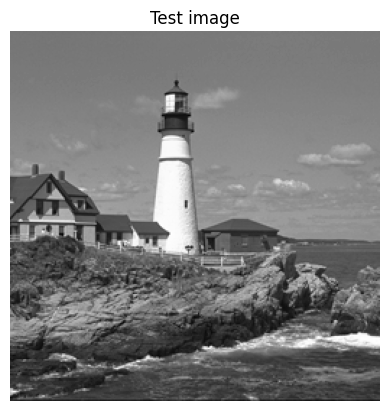

In [43]:
# display test image
plt.imshow(test_img3, cmap='gray')
plt.axis('off')
plt.title('Test image')

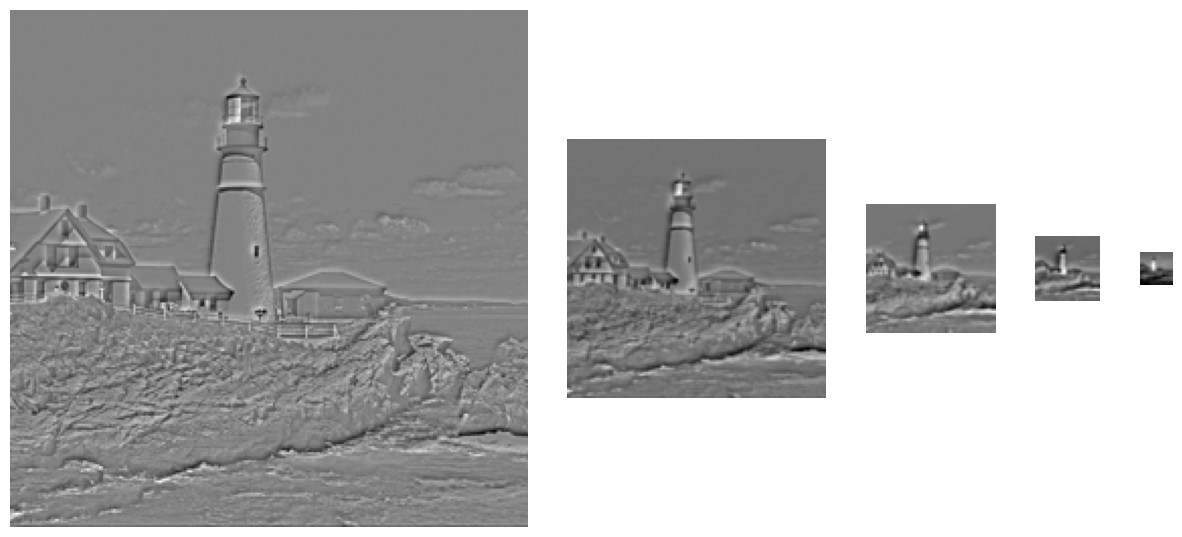

In [44]:
# compute 5 level laplace pyramid
L_pyramid = createLaplacePyramid(test_img3, kernel, 5)

# diplay the pyramid images
plotPyramidToScale(L_pyramid)

#### Now we reconstruct the image from the 5 level pyramid representation

Mean squared error in reconstruction = 0.0


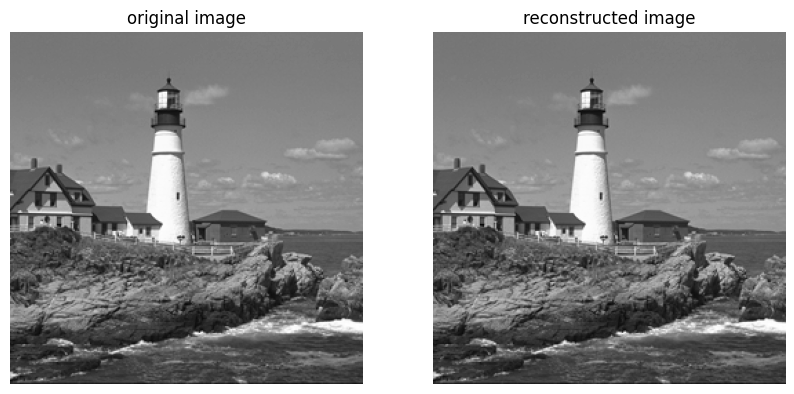

In [45]:
reconstructed_img = reconstructFromPyramid(L_pyramid, kernel)
compareImages(test_img3, reconstructed_img)

#### This is a perfect reconstruction since the two images are identical!

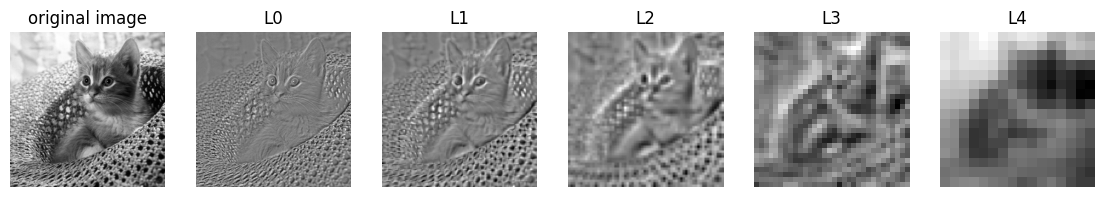

In [46]:
# compute laplace pyramid with 5 levels for the test image
L_pyramid = createLaplacePyramid(test_img1, kernel, 5)
plotPyramid(test_img1, L_pyramid)

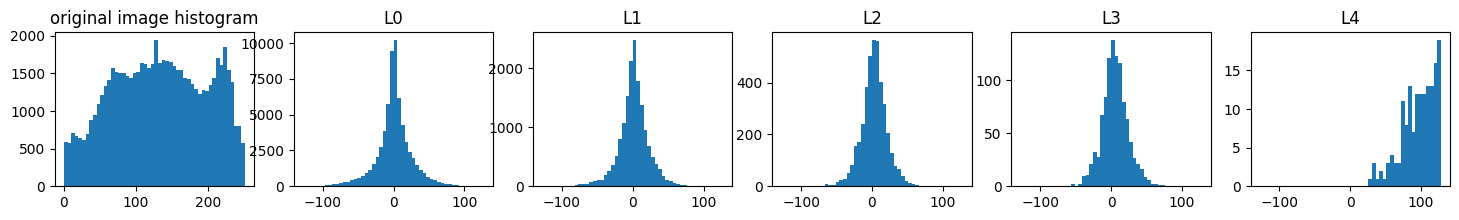

In [47]:
# histograms of difference images
plotPyramidHistograms(test_img1, L_pyramid)

Pixel values of the difference images are sharply concentrated near 0 as a result of decorrelation

### 2. Quantization and compression

#### Below, we implement a function for quantizing an image into $b$ bits. The quantization procedure involves dividing the image pixels into $2^b$ *equal-frequency* bins. This is acheived by flattening the 2d image pixel array into a 1d array and sorting the values in ascending order and splitting this sorted 1d array of pixels into equal sized partitions. Each of these partitions is a bin and the left and right bin edges are just the smallest and largest pixel values respectively that are present in the bin. Then the mean value for the pixels inside each bin are computed and the quantized image is obtained by replacing each pixel in the original image with the mean pixel value of the bin that it occupies.   

#### We also implement functions for creating a quantized Laplacian pyramid of an image and for compressing an image. 

In [107]:
'''
    function for quantizing image into specified number of bits

    Parameters:
    I - 2d image array
    b - number of bits per pixel  
'''
def quantize(I, b):

    # b is assumed to be in [1,7]
    assert (b >= 1) and (b <= 7), print("Invalid input. 'b' must be in the range [1,7]")

    # number of bins
    nbin = 2**b
    # number of pixels in image
    npix = np.size(I)
    # number of pixels per bin (if number of pixels in the image is less than number of bins, then the 
    # mean value per bin is equivalent to the pixel value since each bin contains only one pixel)
    if(npix < nbin):
        nbin = npix
    npix_bin = npix // nbin  

    
    # flatten the image array and sort pixels in increasing order
    I_flat = np.ravel(I)
    I_flat = np.sort(I_flat)

    # create equal-frequency bins of pixels
    bins = []
    for i in range(nbin):
        lo = i*npix_bin
        hi = min((i+1)*npix_bin, npix) 
        bins.append(I_flat[lo:hi])

    # find bin edges
    bin_range = []
    bin_edge = [min(bins[0])-0.01]
    for b in bins:
        bin_edge.append(max(b))
        bin_range.append((min(b), max(b)))

    # place pixels in bins (we use the numpy digitize function to map each pixel to it's corresponding bin number)
    I_bin = np.digitize(I, bin_edge, True)-1

    # compute mean pixel value in each bin
    bin_mean = [np.mean(b) for b in bins]
  
    # quantize the image, i.e. replace each pixel value with the mean value of the bin it belongs to
    replacePixels = np.vectorize(lambda bin_num: bin_mean[bin_num])
    I_quantized = replacePixels(I_bin)

    return I_quantized



'''
    function for creating a laplace pyramid for an input image with quantization

    Parameters:
    I - 2d image array (assumed to be 8 bits per pixel)
    g - 2d gaussian filter array
    n - number of pyramid levels
    b - list of quantization bits per level  
'''
def createLaplacePyramidQuantized(I, g, n, b):
    # list of pyramid images
    L_pyramid = []
    # iterate over pyramid image levels 
    for i in range(n):
        if i < (n-1):
            # filter the image with gaussian kernel
            F = filter(I, g)
            # downsample the filtered image
            D = downsample(F)
            # upsample the image then filter by the gaussian kernel and increase brightness by factor of 4 to compensate for upsampling
            U = filter(upsample(D), 4*g)
            # compute difference image for this level
            L = I - U
            # quantize the difference image
            if(b[i] < 8):
                L = quantize(L, b[i])
            L_pyramid.append(L)
            # use downsampled image as input for next level
            I = D
        else:
            # the last level will not be processed any further
            L_pyramid.append(I)    

    return L_pyramid     


'''
    function for creating a compressed image using its quantized laplacian pyramid

    Parameters:
    I - 2d image array (assumed to be 8 bits per pixel)
    n - number of pyramid levels
    b - list of quantization bits per level  
'''
def compress(I, n, b):
    # generate laplacian pyramid
    L = createLaplacePyramidQuantized(I, kernel, n, b)

    # reconstruct the image from the pyramid
    rec_img = reconstructFromPyramid(L, kernel)

    # compression rate
    bits_image = 8 * 256 * 256
    bits_pyramid = 0
    for i in range(n-1):
        bits_pyramid += b[i] * (256 / pow(2,i)) * (256 / pow(2,i))
    bits_pyramid += 8 * (256 / pow(2,n-1)) * (256 / pow(2,n-1))
    compression = bits_pyramid / bits_image

    return (rec_img, compression)
    

In [108]:
'''
    function for making nice plots of quantized image
'''
def plotQuantized(img):
    plt.figure(figsize=(12,6))
    plt.subplot(2,4,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original, b = 8')
    plt.axis('off')
    
    for i in range(7, 0, -1):
        Q = quantize(img, i)
        plt.subplot(2,4,9-i)
        plt.imshow(Q, cmap='gray')
        plt.title('Quantized, b = '+ str(i))
        plt.axis('off')

'''
    function for making plots comparing compressed images with the original
'''
def compareCompressed(test_img, compressed_img):
    vmin = np.min(test_img)
    vmax = np.max(test_img)

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(test_img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title('Original image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(compressed_img, cmap='gray', vmin=vmin, vmax=vmax)
    plt.title('Compressed image')
    plt.axis('off')

    mse = np.linalg.norm(test_img-compressed_img, ord=2) / np.size(test_img)
    print(f"Mean squared error in compression = {mse}")        

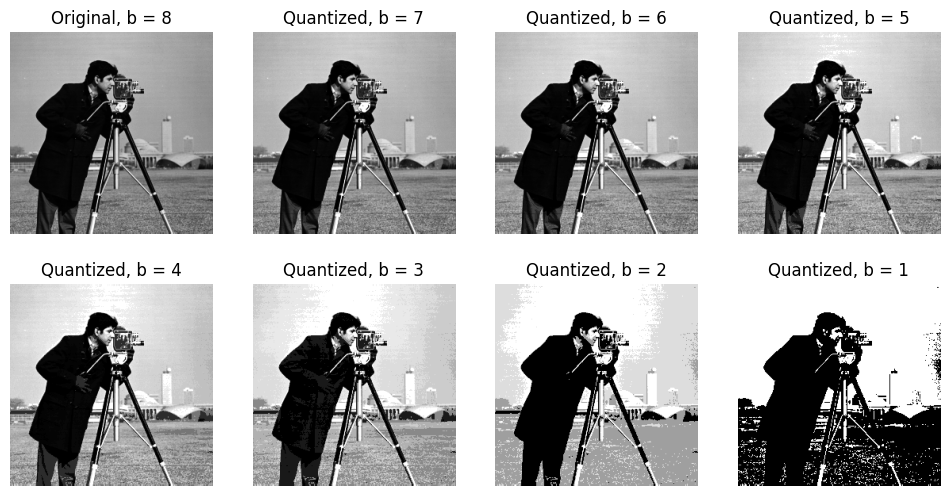

In [109]:
# quntize some test images
plotQuantized(test_img)
#plotQuantized(test_img1)
#plotQuantized(test_img2)
#plotQuantized(test_img3)

Higher number of pyramid levels => more compressions 

Lower b values for quantization, i.e. fewer quantization levels => more compression

more compressions => lower image quality

Need to balance pyramid levels and b values to acheive reasonable compression rate and image quality

Mean squared error in compression = 0.04587052517705338
Compression = 1.1400146484375


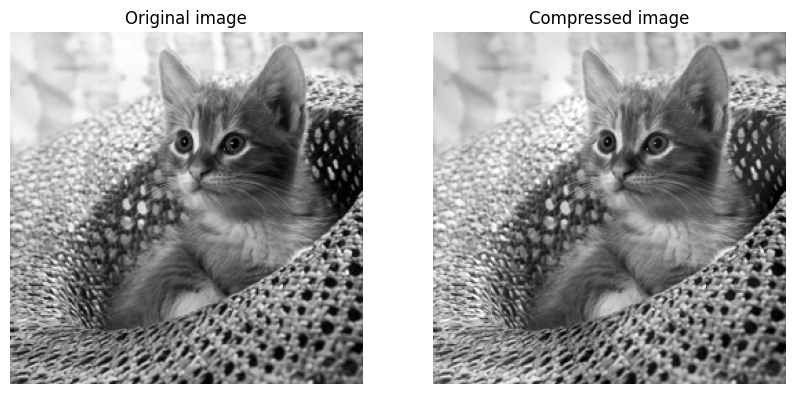

In [88]:
b = [7,7,5,3,2,1,8]
compressed_img, compression = compress(test_img1, 7, b)
compareCompressed(test_img1, compressed_img)
print(f"Compression = {compression}")

Mean squared error in compression = 0.012898647741684605
Compression = 0.3907470703125


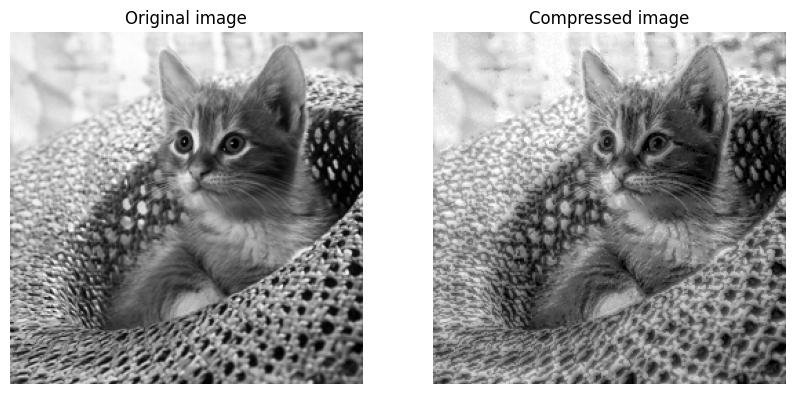

In [89]:
b = [2,3,4,6,6,7,8]
compressed_img, compression = compress(test_img1, 7, b)
compareCompressed(test_img1, compressed_img)
print(f"Compression = {compression}")

Mean squared error in compression = 0.014870748854946667
Compression = 0.3887939453125


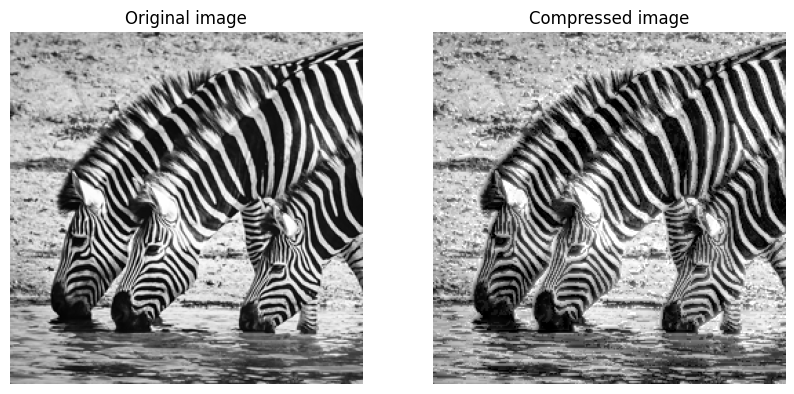

In [92]:
b = [2,3,4,5,6,7,8]
compressed_img, compression = compress(test_img2, 7, b)
compareCompressed(test_img2, compressed_img)
print(f"Compression = {compression}")

Mean squared error in compression = 0.01218185835120306


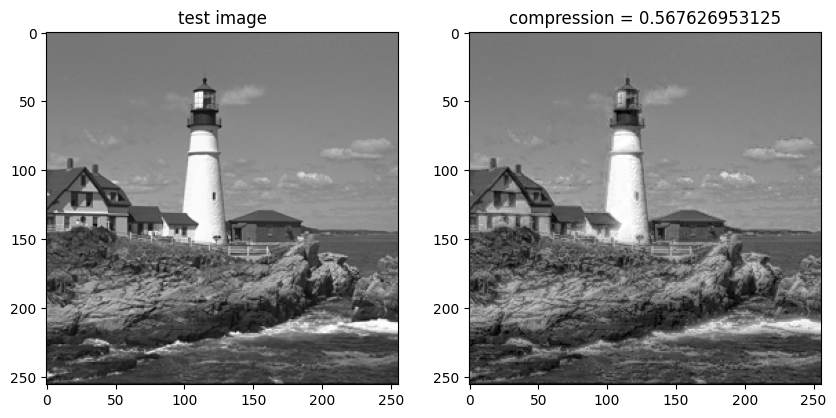

In [ ]:
b = [3,4,6,8,8,8,8]
compressed_img, compression = compress(test_img3, 7, b)
compareCompressed(test_img3, compressed_img)

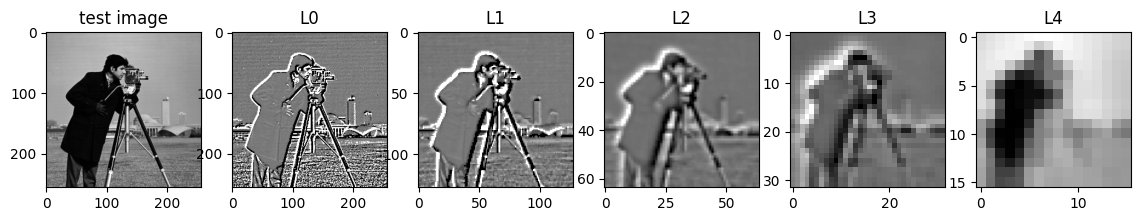

In [ ]:
# laplace pyramid with 5 levels with quantization 
b = [3,4,6,7,7]
L_pyramid_q = createLaplacePyramidQuantized(test_img, kernel, 5, b)
plotPyramid(test_img, L_pyramid_q)

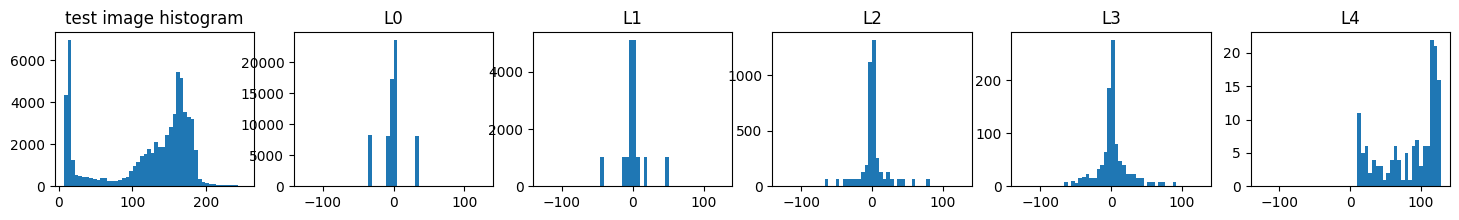

In [ ]:
# histograms of difference images with quantization
plotPyramidHistograms(test_img, L_pyramid_q)

### 3. Evaluation in the frequency domain

In [ ]:
'''
    Code borrowed from workshop 3
'''
# Fast fourier transform of image

def FFT_image(img):
    # Fourier transform
    f = np.fft.fft2(img)
    # Shift the low frequency component to the center
    f = np.fft.fftshift(f)
    
    # Fourier phase and magnitude
    phase = np.angle(f)
    magnitude = np.abs(f)
    # the orginal magnitute is too small, we show log of the value to make it clear
    magnitude_log = np.log(np.abs(f))  

    return (magnitude_log, phase)

def plot_FFT_image_log(img):
    # Fourier transform
    f = np.fft.fft2(img)
    # Shift the low frequency component to the center
    f = np.fft.fftshift(f)
    
    # Fourier phase and magnitude
    phase = np.angle(f)
    magnitude = np.abs(f)
    # the orginal magnitute is too small, we show log of the value to make it clear
    magnitude_log = np.log(np.abs(f))  
    
    #figure size
    plt.subplots(figsize=(7, 7)) 

    # Original image
    plt.subplot(2,2,1)
    plt.imshow(img ,cmap='gray')  
    plt.title('image')
    plt.axis('off')

    # Phase
    plt.subplot(2,2,2)
    plt.imshow(phase ,cmap='gray')  
    plt.title('phase')
    plt.axis('off')
    
    # the orginal magnitude
    plt.subplot(2,2,3)
    plt.imshow(magnitude ,cmap='gray')  
    plt.title('magnitude')
    plt.axis('off')

    # log of the orginal magnitude
    plt.subplot(2,2,4)
    plt.imshow(magnitude_log ,cmap='gray')  
    plt.title('log magnitude')
    plt.axis('off')

    plt.show()

/tmp/ipykernel_278811/382787596.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)


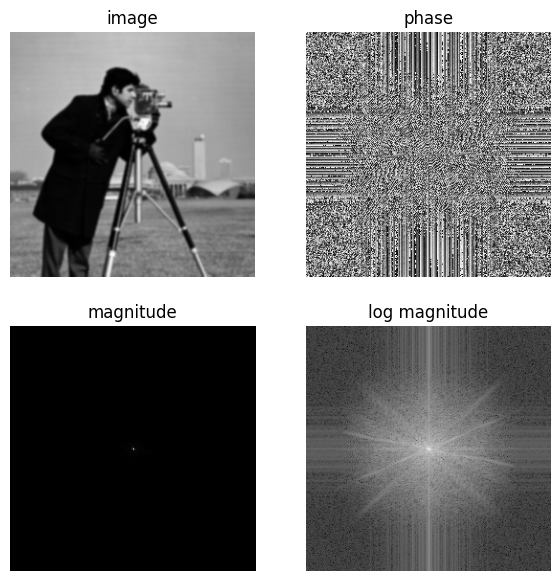

In [ ]:
plot_FFT_image_log(filter(test_img, kernel))

In [ ]:
def plot_FFT_pyramid(img, pyramid):
    n = len(pyramid)

    magnitude_log, phase = FFT_image(img)
    magnitudes = [magnitude_log]
    phases = [phase]
    
    pix_min, pix_max = (np.min(img), np.max(img))
    mag_min, mag_max = (np.min(magnitude_log), np.max(magnitude_log))
    phase_min, phase_max = (np.min(phase), np.max(phase))

    plt.figure(figsize=(18,12))
    plt.subplot(3,n+1,1)
    plt.imshow(img, cmap='gray', vmin=pix_min, vmax=pix_max)
    plt.title('test image')


    count = 2 
    for i in range(n):
        plt.subplot(3,n+1,count)
        plt.imshow(pyramid[i], cmap='gray', vmin=pix_min, vmax=pix_max)
        plt.title('L'+ str(i))
        magnitude_log, phase = FFT_image(pyramid[i])
        magnitudes.append(magnitude_log)
        phases.append(phase)
        count += 1

    plt.subplot(3,n+1,count)
    plt.imshow(magnitudes[0], cmap='gray', vmin=mag_min, vmax=mag_max)
    count += 1
    for i in range(n):
        plt.subplot(3,n+1,count)
        plt.imshow(magnitudes[i+1], cmap='gray', vmin=mag_min, vmax=mag_max)
        count += 1

    plt.subplot(3,n+1,count)
    plt.imshow(phases[0], cmap='gray', vmin=phase_min, vmax=phase_max)
    count += 1
    for i in range(n):
        plt.subplot(3,n+1,count)
        plt.imshow(phases[i+1], cmap='gray', vmin=phase_min, vmax=phase_max)
        count += 1  

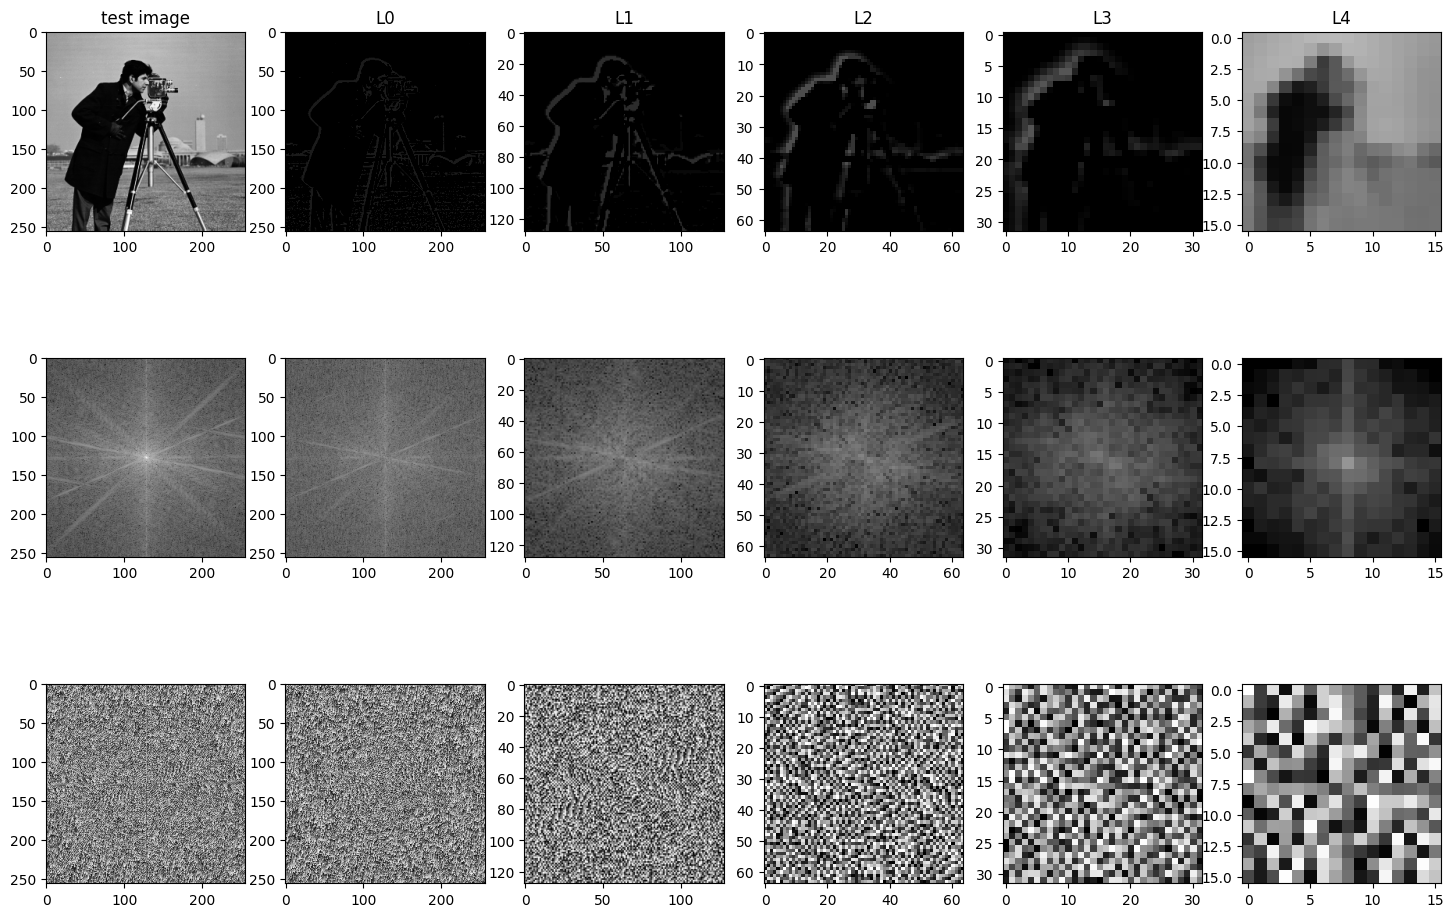

In [ ]:
plot_FFT_pyramid(test_img, L_pyramid_q)

In [ ]:
def compareCompressedFFT(test_img, compressed_img):
    pix_min = np.min(test_img)
    pix_max = np.max(test_img)

    test_magnitude_log, test_phase = FFT_image(test_img)
    compressed_magnitude_log, compressed_phase = FFT_image(compressed_img)
    
    mag_min, mag_max = (np.min(test_magnitude_log), np.max(test_magnitude_log))
    phase_min, phase_max = (np.min(test_phase), np.max(test_phase))

    plt.figure(figsize=(13,10))

    plt.subplot(2,3,1)
    plt.imshow(test_img, cmap='gray', vmin=pix_min, vmax=pix_max)
    plt.ylabel('test image')

    plt.subplot(2,3,2)
    plt.imshow(test_magnitude_log, cmap='gray', vmin=mag_min, vmax=mag_max)

    plt.subplot(2,3,3)
    plt.imshow(test_phase, cmap='gray', vmin=phase_min, vmax=phase_max)

    plt.subplot(2,3,4)
    plt.imshow(compressed_img, cmap='gray', vmin=pix_min, vmax=pix_max)
    plt.ylabel('compressed')

   
    plt.subplot(2,3,5)
    plt.imshow(compressed_magnitude_log, cmap='gray', vmin=mag_min, vmax=mag_max)

    plt.subplot(2,3,6)
    plt.imshow(compressed_phase, cmap='gray', vmin=phase_min, vmax=phase_max)



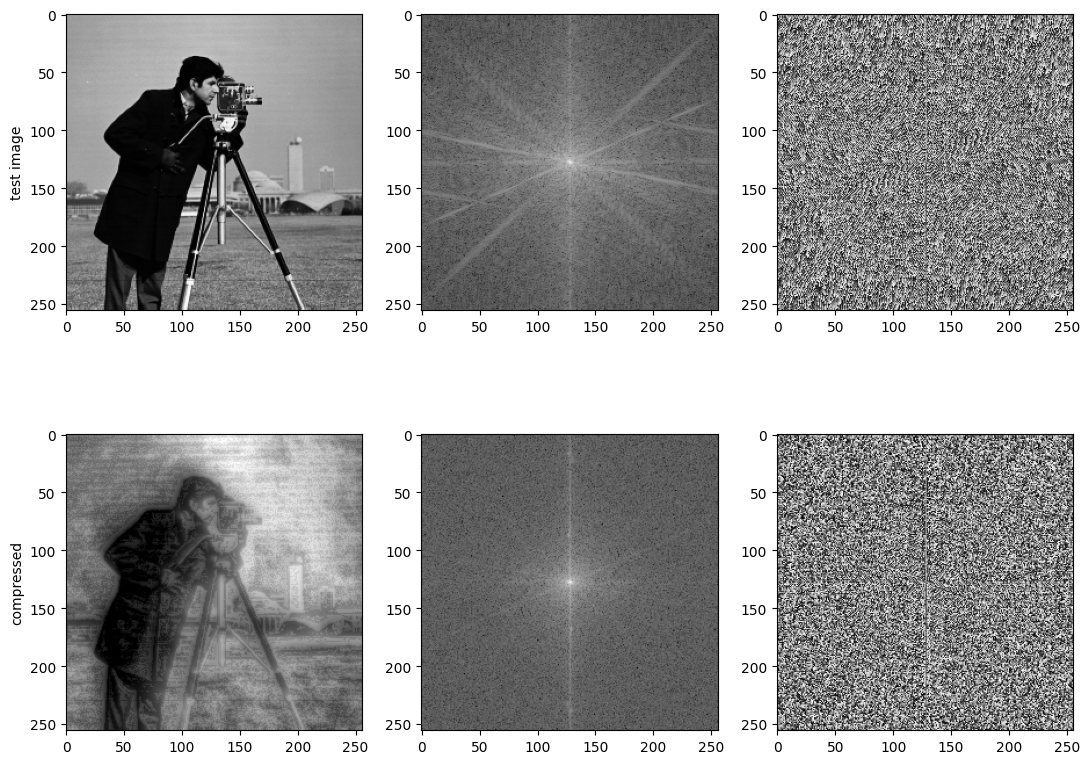

In [ ]:
b = [1,1,1,1,2,2,8]
compressed_img, compression = compress(test_img, 7, b)
compareCompressedFFT(test_img, compressed_img)

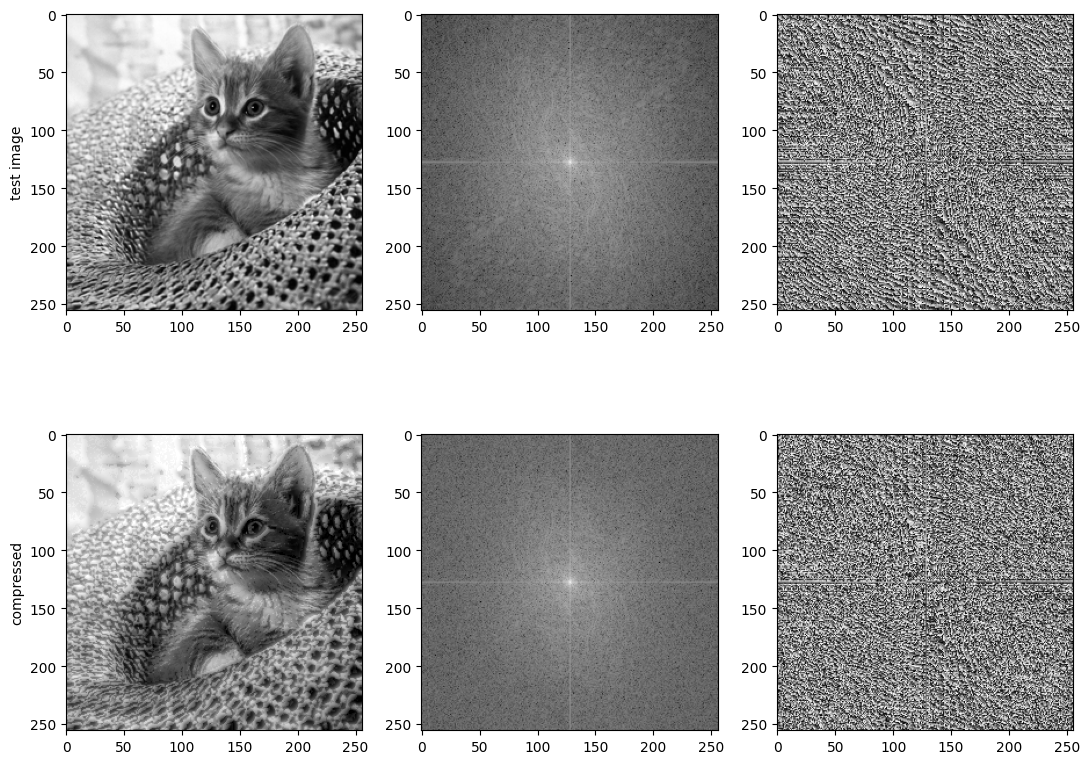

In [ ]:
b = [2,3,5,6,6,7,8]
compressed_img, compression = compress(test_img1, 7, b)
compareCompressedFFT(test_img1, compressed_img)


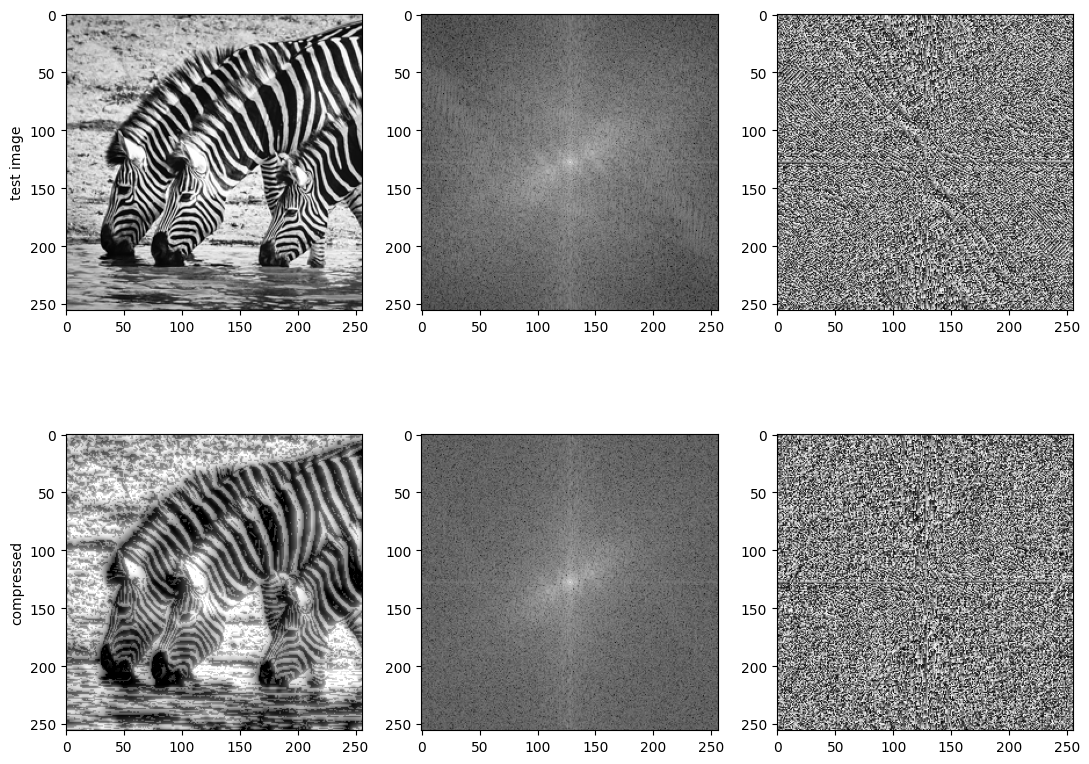

In [ ]:
b = [1,1,2,6,6,7,8]
compressed_img, compression = compress(test_img2, 7, b)
compareCompressedFFT(test_img2, compressed_img)

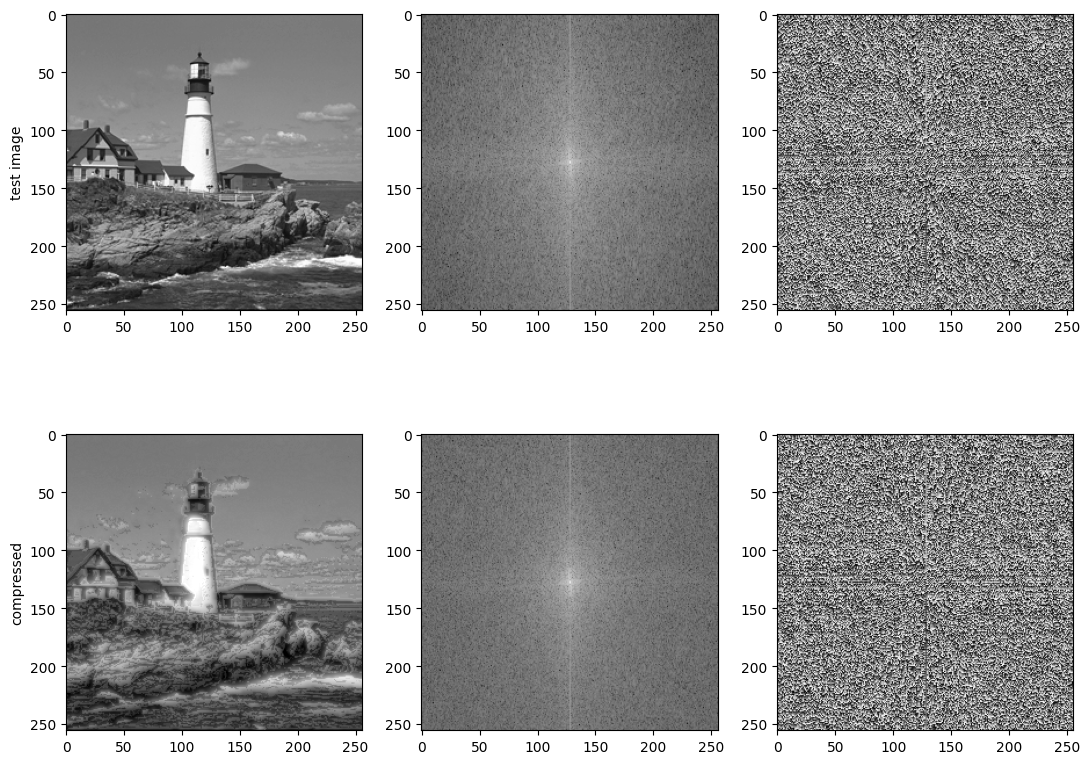

In [ ]:
b = [2,3,4,8,8,8,8]
compressed_img, compression = compress(test_img3, 7, b)
compareCompressedFFT(test_img3, compressed_img)